# Angular momentum budget during the spin-up phase

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from tqdm.notebook import tqdm

In [3]:
import iris
import iris.quickplot as qplt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm
from matplotlib.offsetbox import AnchoredText

In [4]:
# My packages and local scripts
import aeolus

print(aeolus.__version__)


from aeolus.calc import (
    meridional_mean,
    spatial,
    spatial_mean,
    time_mean,
    vertical_mean,
    zonal_mean,
)
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import (
    get_cube_rel_days,
    interp_cube_from_height_to_pressure_levels,
    interp_cubelist_from_height_to_pressure_levels,
    isel,
)
from aeolus.io import load_data
from aeolus.meta import const_from_attrs
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    fmt_lonlat,
    subplot_label_generator,
    tex2cf_units,
)
from aeolus.subset import l_range_constr

0.4.13+22.g6e7cfd9


In [5]:
import mypaths
from pouch.clim_diag import (
    calc_derived_cubes,
    d_dphi,
    rolling_mean,
)
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    KW_ZERO_LINE,
    XLOCS,
    YLOCS,
    add_aux_yticks,
    figsave,
    linspace_pm1,
    use_style,
)

In [6]:
from commons import (
    GLM_SUITE_ID,
    SIM_LABELS,
    eq_lat,
    free_troposphere,
    mid_lat,
    midlatitudes,
    ss_lon,
    tropics,
    troposphere,
)

In [7]:
from angular_momentum_budget import AngularMomentumBudget

In [8]:
use_style()

bg_color = mpl.colors.to_rgb(plt.rcParams["figure.facecolor"])
fg_color = mpl.colors.to_rgb(plt.rcParams["text.color"])

In [9]:
img_prefix = f"{GLM_SUITE_ID}_spinup"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_spinup"
time_prof = "mean_days0_499"
plotdir = mypaths.plotdir / img_prefix

In [10]:
# Load processed data
runs = {}
for sim_label, sim_prop in tqdm(SIM_LABELS.items()):
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Derive additional fields
    calc_derived_cubes(cl, const=const, model=um)
    # Use the cube list to initialise an AtmoSim object
    runs[sim_label] = AngularMomentumBudget(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="z",
    )

  0%|          | 0/2 [00:00<?, ?it/s]

## Vertical profiles

In [47]:
reduce = lambda cube: spatial_mean(
    # cube.extract(iris.Constraint(**{um.y: lambda x: 55 <= abs(x.point) <= 65}))
    cube.extract(iris.Constraint(**{um.y: lambda x: 0 <= abs(x.point) <= 15}))
)
region_name = "tropics"

In [48]:
periods = {
    # "first": {"days": [0, 20], "lim": [-20, 40]},
    # "second": {"days": [20, 80], "lim": [-30, 40]},
    # "third": {"days": [100, 200], "lim": [-100, 110]},
    # "fourth": {"days": [250, 500], "lim": [-100, 110]},
    "first": {"days": [0, 20], "lim": [-20, 40]},
    "second": {"days": [20, 80], "lim": [-30, 40]},
    "third": {"days": [100, 200], "lim": [-150, 150]},
    "fourth": {"days": [250, 500], "lim": [-150, 150]},
}

tm_suffix = "_".join("-".join(str(j) for j in i["days"]) for i in periods.values())

In [49]:
terms_to_show = AngularMomentumBudget.term_group_labels

vrbl_keys = ["ang_mom_bud", "rho_ang_mom_time_change"]
main_key, aux_key = vrbl_keys
imgname = (
    f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__{'_'.join(vrbl_keys)}__{tm_suffix}__vprof_{region_name}"
)

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k__ang_mom_bud_rho_ang_mom_time_change__0-20_20-80_100-200_250-500__vprof_tropics.png


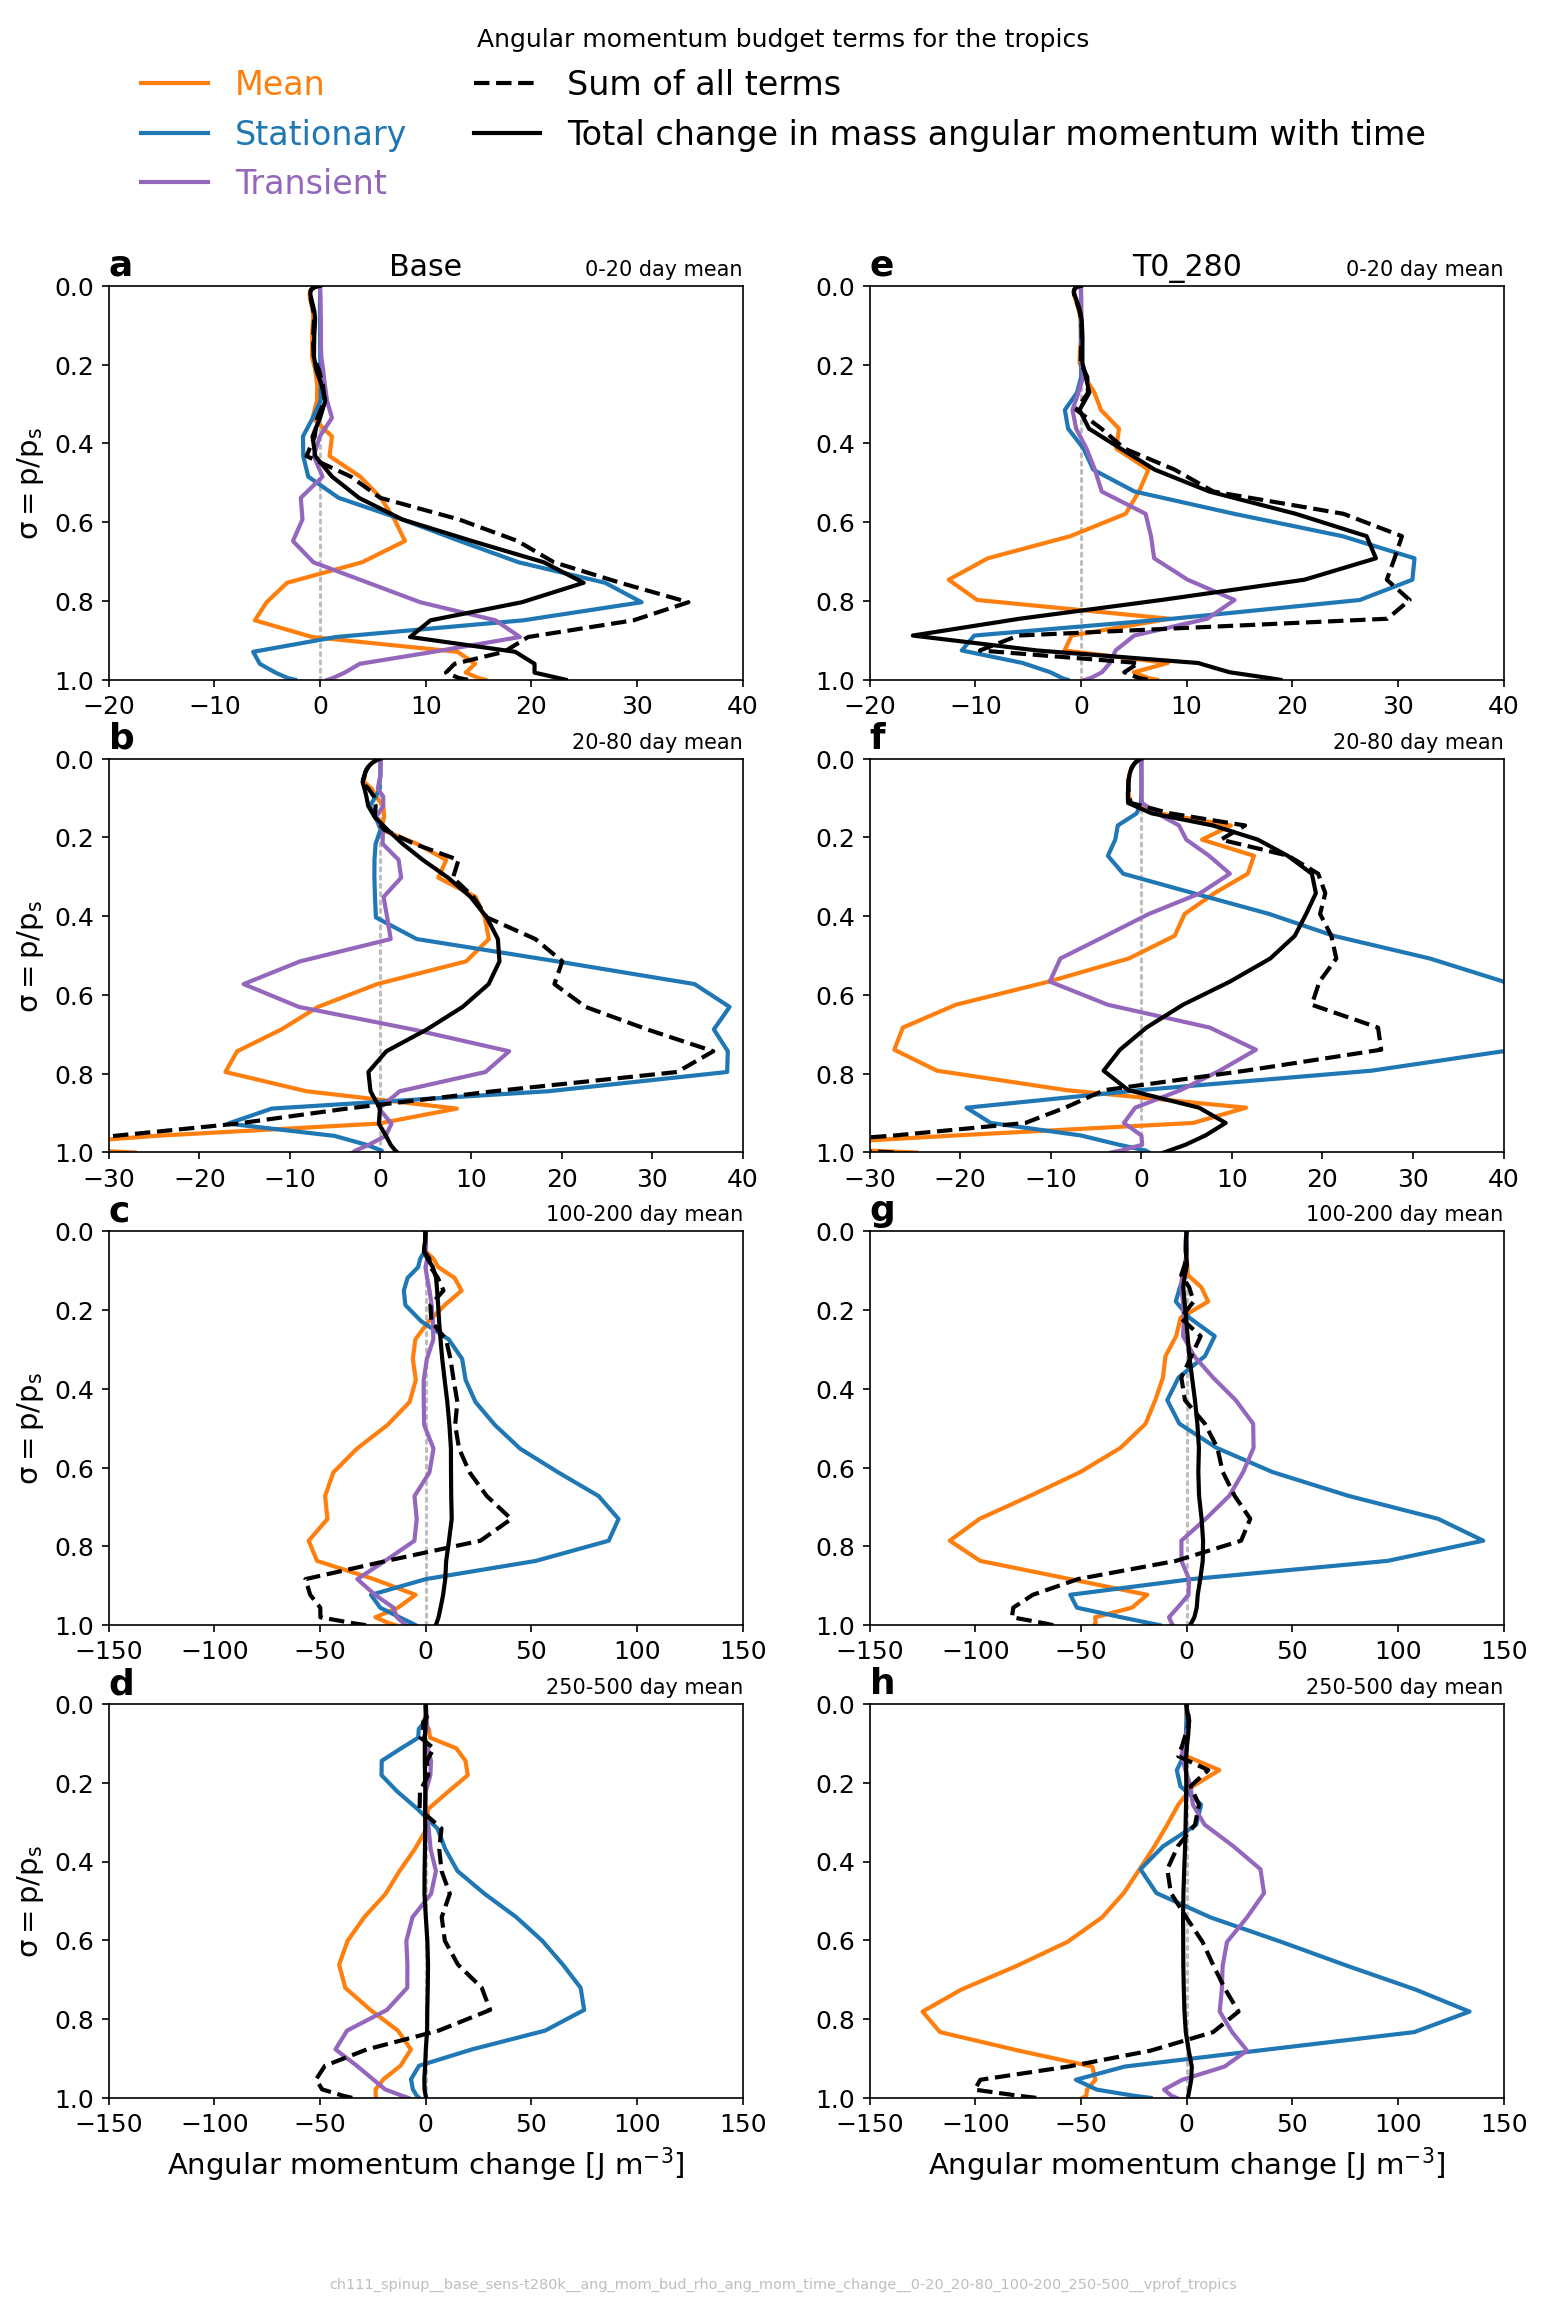

In [50]:
ylim = [1, 0]
kw_common = dict(linewidth=2)

ncols = len(SIM_LABELS)
nrows = len(periods)
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(ncols * 6, nrows * 4),
    # gridspec_kw=dict(hspace=0.25),
)
iletters = subplot_label_generator()
for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    # du_dt_zm = deriv(rho_u_zm, um.t)
    # du_dt_zm.convert_units(tex2cf_units(tex_units))
    axcol[0].set_title(f"{sim_prop['title']}", **KW_MAIN_TTL)
    for (period_key, period_prop), ax in zip(periods.items(), axcol):
        # ax2 = ax.twiny()
        # ax2.spines["top"].set_position(("axes", -0.15))
        # ax2.set_xlim([-5, 30])
        # ax2.tick_params(axis="x", direction="in", pad=-15)
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        ax.axvline(**KW_ZERO_LINE)
        ax.set_ylim(ylim)
        ax.set_xlim(period_prop.get("lim"))
        day_start, day_end = period_prop["days"]
        day_constr = iris.Constraint(
            **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
        )
        ax.set_title(f"{day_start}-{day_end} day mean", **KW_AUX_TTL)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"$\sigma=p/p_s$")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(f"Angular momentum change [{AngularMomentumBudget.tex_units}]")
        # ax2.set_xlabel(f"Zonal mean zonal mass flux [{tex_units2}]", labelpad=-30)

        the_run = runs[sim_label].extract(day_constr)
        _sigma_p = the_run.sigma_p_tsm

        term_sum = []
        for i, term_label in enumerate(terms_to_show):
            term = the_run[term_label]
            kw_plt = dict(color=term.attributes["color"])
            # Collapse diagnostics
            cube = reduce(term)
            # Plot diagnostics
            ax.plot(cube.data, _sigma_p.data, **kw_common, **kw_plt)
            term_sum.append(cube)
        cube = sum(term_sum)
        ax.plot(
            cube.data,
            _sigma_p.data,
            color="k",
            linestyle="--",
            **kw_common,
        )

        cube = reduce(the_run[aux_key])
        ax.plot(
            cube.data,
            _sigma_p.data,
            color="k",
            linestyle="-",
            **kw_common,
        )

add_custom_legend(
    fig,
    {
        **{
            f'{the_run[term_label].attributes["title"]}': {
                **kw_common,
                "color": the_run[term_label].attributes["color"],
            }
            for term_label in terms_to_show
        },
        **{
            "Sum of all terms": dict(
                color="k",
                linestyle="--",
                **kw_common,
            ),
            f'{the_run[aux_key].attributes["title"]}': dict(
                color="k",
                linestyle="-",
                **kw_common,
            ),
        },
    },
    loc="upper center",
    bbox_to_anchor=(0.5, 1.0),
    frameon=False,
    ncol=2,
    title=f"Angular momentum budget terms for the {region_name}",
)

figsave(fig, plotdir / imgname)

---

## Latitude-height cross-sections

In [11]:
YZ_VRBL = {
    "ang_mom_bud": {
        "title": "Angular momentum change",
        "kw_plt": dict(cmap=cm.vik, levels=linspace_pm1(10) * 100, extend="both"),
    },  # norm=mpl.colors.CenteredNorm(),
    "rho_ang_mom_time_change": {
        "title": r"$\frac{\Delta[\rho m]}{\Delta T}$",
        "cube": lambda AS: AS.rho_ang_mom_time_change,
        "kw_plt": dict(
            colors=mpl.colors.to_hex(fg_color),
            linewidths=0.5,
            levels=linspace_pm1(50) * 100,
        ),
    },
    "rho_u_tzm": {
        "title": "Zonal mass flux",
        "cube": lambda AS: AS.rho_u_tzm,
        "kw_plt": dict(
            colors=mpl.colors.to_hex(fg_color),
            linewidths=0.5,
            levels=linspace_pm1(50) * 100,
        ),
    },
    "u_tzm": {
        "title": "Zonal wind",
        "cube": lambda AS: AS.u_tzm,
        "kw_plt": dict(
            colors=mpl.colors.to_hex(fg_color),
            linewidths=0.5,
            levels=linspace_pm1(20) * 100,
        ),
    },
}

In [12]:
day_middle = 50
day_half_window = 50
day_start = day_middle - day_half_window
day_end = day_middle + day_half_window
day_constr = iris.Constraint(
    **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
)
tm_title = f"{day_start}-{day_end} days mean"
tm_suffix = f"day{day_start:03d}-{day_end:03d}_mean"

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k__ang_mom_bud_rho_ang_mom_time_change__day000-100_mean.png


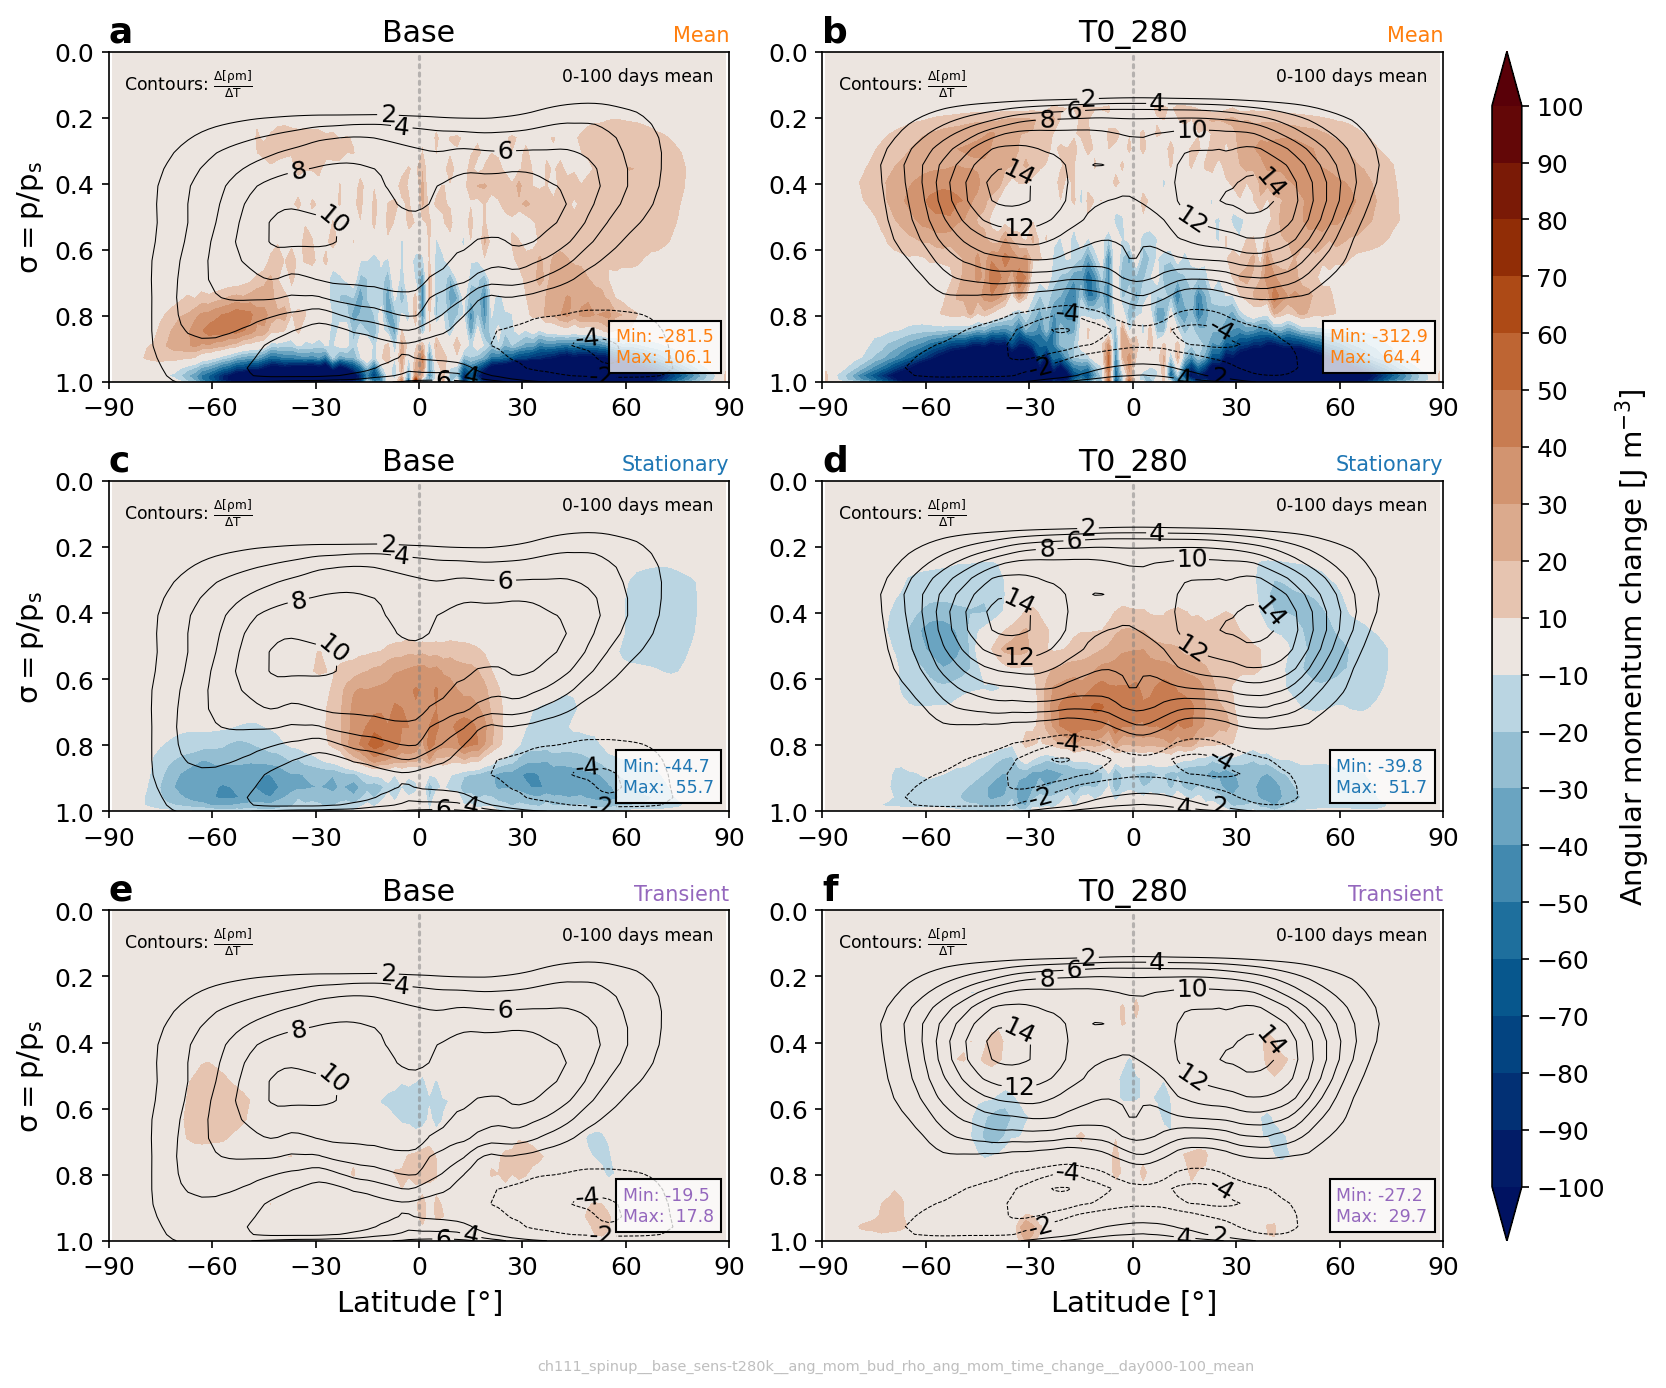

In [13]:
add_min_max = True
vrbl_keys = ["ang_mom_bud", "rho_ang_mom_time_change"]
main_key, aux_key = vrbl_keys
imgname = (
    f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__{'_'.join(vrbl_keys)}__{tm_suffix}"
)

_term_labels = AngularMomentumBudget.term_group_labels
# _term_labels = AngularMomentumBudget.term_labels

ncols = len(SIM_LABELS)
nrows = len(_term_labels)

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 7, nrows * 3.5), squeeze=False
)

iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_ylim([1, 0])
    ax.axvline(**KW_ZERO_LINE)
    ax.set_xticks(YLOCS)
    ax.set_xlim(YLOCS[0], YLOCS[-1])
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("$\sigma=p/p_s$")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Latitude [$\degree$]")
    # if ax.get_subplotspec().is_last_col() and ax.get_subplotspec().is_first_row():
    ax.add_artist(
        AnchoredText(
            tm_title, frameon=False, prop=dict(size="x-small"), loc="upper right"
        )
    )
    # if ax.get_subplotspec().is_first_col() and ax.get_subplotspec().is_first_row():
    ax.add_artist(
        AnchoredText(
            f"Contours: {YZ_VRBL[aux_key]['title']}",
            frameon=False,
            prop=dict(size="x-small"),
            loc="upper left",
        )
    )
for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    the_run = runs[sim_label].extract(day_constr)
    for ax, term_label in zip(axcol, _term_labels):
        cube_a = the_run[term_label]
        term_attr = cube_a.attributes
        term_color = term_attr.get("color", fg_color)
        ax.set_title(sim_prop["title"], **KW_MAIN_TTL)
        ax.set_title(term_attr["title"], color=term_color, **KW_AUX_TTL)
        if term_tex := term_attr.get("tex"):
            at = AnchoredText(
                f"${term_tex}$",
                prop=dict(color=term_color),
                frameon=True,
                pad=0.2,
                loc="lower left",
            )
            at.patch.set_facecolor(mpl.colors.to_rgba(bg_color, alpha=0.75))
            ax.add_artist(at)
        if add_min_max:
            cube_a_min = cube_a.data.min()
            cube_a_max = cube_a.data.max()
            at = AnchoredText(
                f"Min: {cube_a_min:>5.1f}\nMax: {cube_a_max:>5.1f}",
                prop=dict(color=term_color, size="x-small"),
                frameon=True,
                loc="lower right",
            )
            at.patch.set_facecolor(mpl.colors.to_rgba(bg_color, alpha=0.75))
            ax.add_artist(at)

        cntrf = ax.contourf(
            the_run.coord.y.points,
            the_run.sigma_p_tsm.data,
            cube_a.data,
            **YZ_VRBL[main_key]["kw_plt"],
        )
        cube_b = YZ_VRBL[aux_key]["cube"](the_run)
        cntr = ax.contour(
            the_run.coord.y.points,
            the_run.sigma_p_tsm.data,
            cube_b.data,
            **YZ_VRBL[aux_key]["kw_plt"],
        )
        clbls = ax.clabel(cntr, fmt="%.f", colors=YZ_VRBL[aux_key]["kw_plt"]["colors"])
fig.subplots_adjust(wspace=0.15, hspace=0.3)
cb = fig.colorbar(cntrf, ax=axs, pad=0.03, aspect=40)
cb.set_ticks(YZ_VRBL[main_key]["kw_plt"]["levels"])
cb.ax.set_ylabel(f"{YZ_VRBL[main_key]['title']} [{the_run.tex_units}]")
figsave(fig, plotdir / imgname)

---

In [ ]:
the_run = runs["sens-t280k"].extract(day_constr)

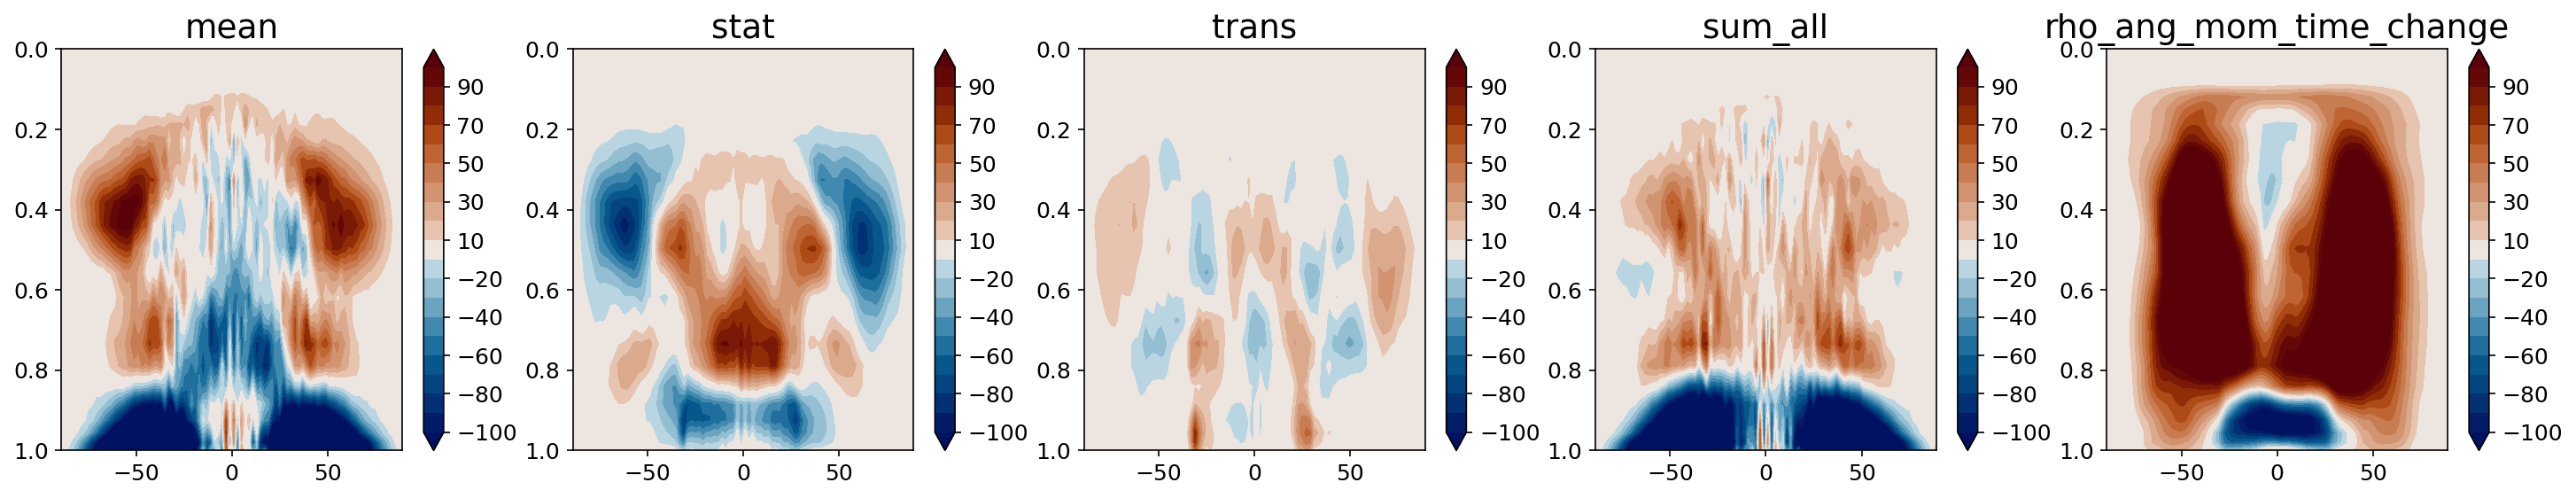

In [212]:
fig, axs = plt.subplots(ncols=len(labels), nrows=1, figsize=(24, 4))
for ax, term_label in zip(axs.flat, labels):
    ax.set_title(term_label)
    _p0 = ax.contourf(
        the_run.coord.y.points,
        time_mean(spatial_mean(the_run.sigma_p)).data,
        the_run[term_label].data,
        **kw_common
    )
    ax.set_ylim(1, 0)
    fig.colorbar(_p0, ax=ax)